In [1]:
%reload_ext autoreload
%autoreload 2

Prep

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import pandas as pd
pd.set_option('display.max_rows', 200)

from tqdm import tqdm
import getpass
import logging

logging.basicConfig(level=logging.ERROR)

In [3]:
from adapter_covid19.data_structures import Scenario, ModelParams
from adapter_covid19.simulator import Simulator

Initialize simulator

In [4]:
data_path = f"/home/{getpass.getuser()}/adaptER-covid19/tests/adapter_covid19/data"

simulator = Simulator(data_path)

Inialize scenarios

Run spread model once

In [5]:
import example_utils as utils

def get_ill_dead_ratio_from_spread_model(data_folder: str, lockdown_start: int = 0, lockdown_end:int = 0, end: int=50, reload: bool = False):
    file_name = f'spread_model_cache_{lockdown_start}_{lockdown_end}_{end}.pkl'
    file_path = os.path.join(data_folder, file_name)
    if not os.path.exists(file_path) or reload:
        population = 10000
        params = utils.get_baseline_parameters()
        params.set_param( "n_total", population )

        sim = utils.get_simulation( params )

        sim.steps( lockdown_start )

        sim.env.model.update_running_params("lockdown_on", 1)
        sim.steps( lockdown_end - lockdown_start)

        sim.env.model.update_running_params("lockdown_on", 0)
        sim.steps( end - lockdown_end )

        timeseries = pd.DataFrame( sim.results )
        ill_ratio = timeseries["n_symptoms"]  / population
        dead_ratio = timeseries["n_death"] / population

        df = pd.concat([
            ill_ratio.rename('ill ratio'),
            dead_ratio.rename('dead ratio'),
        ], axis=1)
        
        pickle.dump(df, open(file_path, 'wb'))
        return df
    else:
        return pickle.load(open(file_path, 'rb'))

In [6]:
_df = get_ill_dead_ratio_from_spread_model(data_path, 0, 0, 203)
ill_ratio_no_lockdown, dead_ratio_no_lockdown = _df['ill ratio'], _df['dead ratio']

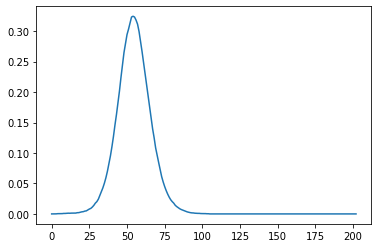

In [7]:
ill_ratio_no_lockdown.plot()

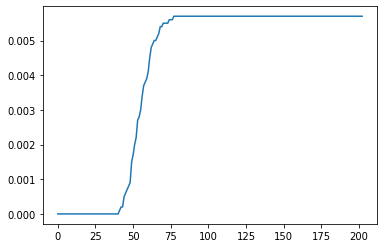

In [8]:
dead_ratio_no_lockdown.plot()

In [9]:
_df = get_ill_dead_ratio_from_spread_model(data_path, 10, 59, 203)
ill_ratio_with_lockdown, dead_ratio_with_lockdown = _df['ill ratio'], _df['dead ratio']

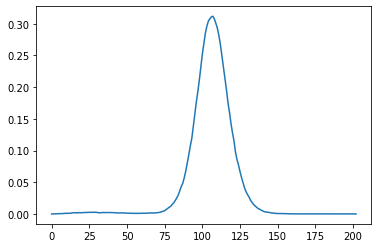

In [10]:
ill_ratio_with_lockdown.plot()

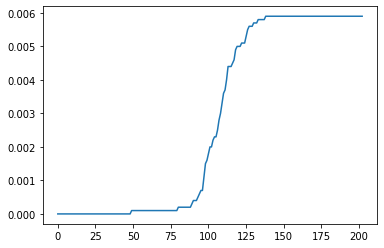

In [21]:
dead_ratio_with_lockdown.plot()

In [13]:
from adapter_covid19.scenarios import BASIC_SCENARIO, BASIC_MODEL_PARAMS

In [14]:
scenarios = { 
    'With Lockdown': Scenario(
        lockdown_recovery_time=1,
        lockdown_start_time=10,
        lockdown_end_time=59,
        furlough_start_time=10,
        furlough_end_time=202,
        simulation_end_time=202,
        new_spending_day=10,
        ccff_day=10,
        loan_guarantee_day=10,
        model_params=BASIC_MODEL_PARAMS,
        ill_ratio=ill_ratio_with_lockdown,
        dead_ratio=dead_ratio_with_lockdown,
    ),
    'No Lockdown': Scenario(
        lockdown_recovery_time=1,
        lockdown_start_time=10000,
        lockdown_end_time=10000,
        furlough_start_time=10000,
        furlough_end_time=10000,
        simulation_end_time=202,
        new_spending_day=10000,
        ccff_day=10000,
        loan_guarantee_day=10000,
        model_params=BASIC_MODEL_PARAMS,
        ill_ratio=ill_ratio_no_lockdown,
        dead_ratio=dead_ratio_no_lockdown,
    ),
}

In [15]:
result = simulator.simulate_multi(scenarios, show_plots=True, figsize=(5, 15))

  5%|▍         | 10/202 [00:29<08:31,  2.67s/it]/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/adapter_covid19/gdp.py:994: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  options={"maxiter": 1e4, "disp": False, "autoscale": False},
/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 67/202 [06:09<12:24,  5.52s/it]


KeyboardInterrupt: 

Metrics

In [11]:
econ, states = result['10 days only']

In [12]:
from adapter_covid19.metrics import get_quarterly_gdp_decline, get_quarterly_demand_decline

In [13]:
starting_date = pd.Timestamp('2020-03-28').date()

In [14]:
get_quarterly_gdp_decline(starting_date, states)

,GDP decline simulation,GDP decline estimates
2020-03-31,0.999242,0.97
2020-06-30,0.548113,0.75
2020-09-30,NaN,NaN
2020-12-31,NaN,0.86


In [15]:
get_quarterly_demand_decline(starting_date, econ, states)

,Demand decline simulation,Demand decline estimates
2020-03-31,1.000000,0.70
2020-06-30,0.971373,0.55


In [17]:
from adapter_covid19.enums import EmploymentState, Region, Sector, Age

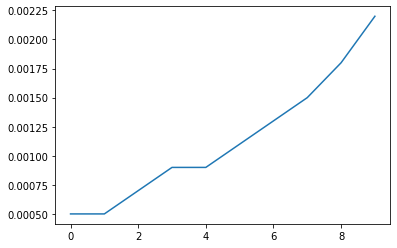

In [19]:
plt.plot([state.ill[(EmploymentState.WFO, Region.C_NE, Sector.A_AGRICULTURE, Age.A18)] for state in states])